<a href="https://colab.research.google.com/github/mandersch/RTIDS/blob/main/adapted_hhl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install qiskit[visualization]
!pip install qiskit-aer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 84.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 8.2 MB/s eta 0:00:00
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=2304369c5667cf6b8452c37338b0a8c5d1519f14f261149fe69f187bebd60b80
  Stored in directory: /root/.cache/pip/wheels/d3/31/8b/e09b0386afd80cfc556c00408c9aeea5c35c4d484a9c762fd5
Successfully built pylatexenc
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 85.2 MB/s eta 0:00:00


In [ ]:
############################################
############# DECLARATION ##################
############################################

import numpy as np
import cmath
from random import seed,random
from math import sqrt

from qiskit.circuit.library import RealAmplitudes, UnitaryGate, QFT, UGate, StatePreparation

np.set_printoptions(suppress=False)
seed()

# Define Input and Operator Size
INPUT = 1

# Define Random  Black Box Operator
theta = 2 * cmath.pi * random()
alpha = andom()
gamma = random()

# op_mat = [[cmath.exp(2 * cmath.pi * 1j * alpha), 0],[0, cmath.exp(2 * cmath.pi * 1j * gamma)]]
op_mat = UGate(theta=2*theta, phi=gamma, lam=alpha)

# Original State |x> Amplitudes
x_amps = [1/2, sqrt(3)/2]

b_amps = np.matmul(op_mat,x_amps)
print("Target:",np.square(x_amps))

In [ ]:
############################################
############ MAIN ALGORITHM ################
############################################

from qiskit import transpile
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import RealAmplitudes, UnitaryGate, QFT, UGate, StatePreparation
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.quantum_info import SparsePauliOp, partial_trace
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2, SamplerV2

from math import sqrt, pow, cos, sin
import cmath
import numpy as np

CONT = 18
AUX = 1

ops = []
for i in range(CONT):
    ops.append(UnitaryGate(np.linalg.matrix_power(op_mat,2**i),f"A^(2^{i})").control(1))

# Define iQFT for later use
iqft = QFT(num_qubits=CONT,inverse=True,approximation_degree=0).to_gate()
qft = QFT(num_qubits=CONT,inverse=False,approximation_degree=0).to_gate()

# Instantiate Quantum Registers
a = QuantumRegister(AUX, "Auxiliary")
b = QuantumRegister(INPUT, "Input")
c = QuantumRegister(CONT, "Control")

b_list = [b] if INPUT == 1 else b[0:INPUT]

# Create a new circuit with these registers
qc = QuantumCircuit(a,c,b)

# Initialize the input register
qc.initialize(b_amps, b)
qc.barrier()

# Add a Initial Distribution to control register
for q in c : qc.h(q)
qc.barrier()

# CA powers
for i in range(CONT):
    qc.append(ops[CONT-i-1],[c[i]] + b_list)
qc.barrier()

# iQFT
qc.append(iqft,qargs=c)
qc.barrier()

# CR_t
for i,q in enumerate(reversed(c)):
    qc.crz(2*cmath.pi/(pow(2,i)),q,a)
qc.barrier()

# iQFT
qc.append(iqft,qargs=c)
qc.barrier()

# CA
for i in range(CONT):
    qc.append(ops[CONT-i-1],[c[i]] + b_list)
qc.barrier()

# Hadamard
for q in c : qc.h(q)
qc.save_statevector()

# Transpile the circuit for the Aer simulator
sim = AerSimulator()
tqc = transpile(qc, sim)

# Execute the circuit and get the statevector
result = sim.run(tqc).result()
full_statevector = result.get_statevector(tqc)
partial_density_matrix = partial_trace(full_statevector,list(range(AUX + CONT)))
statevector = np.diagonal(partial_density_matrix)

# Print the statevector of the output qubits
print("State: ", statevector)

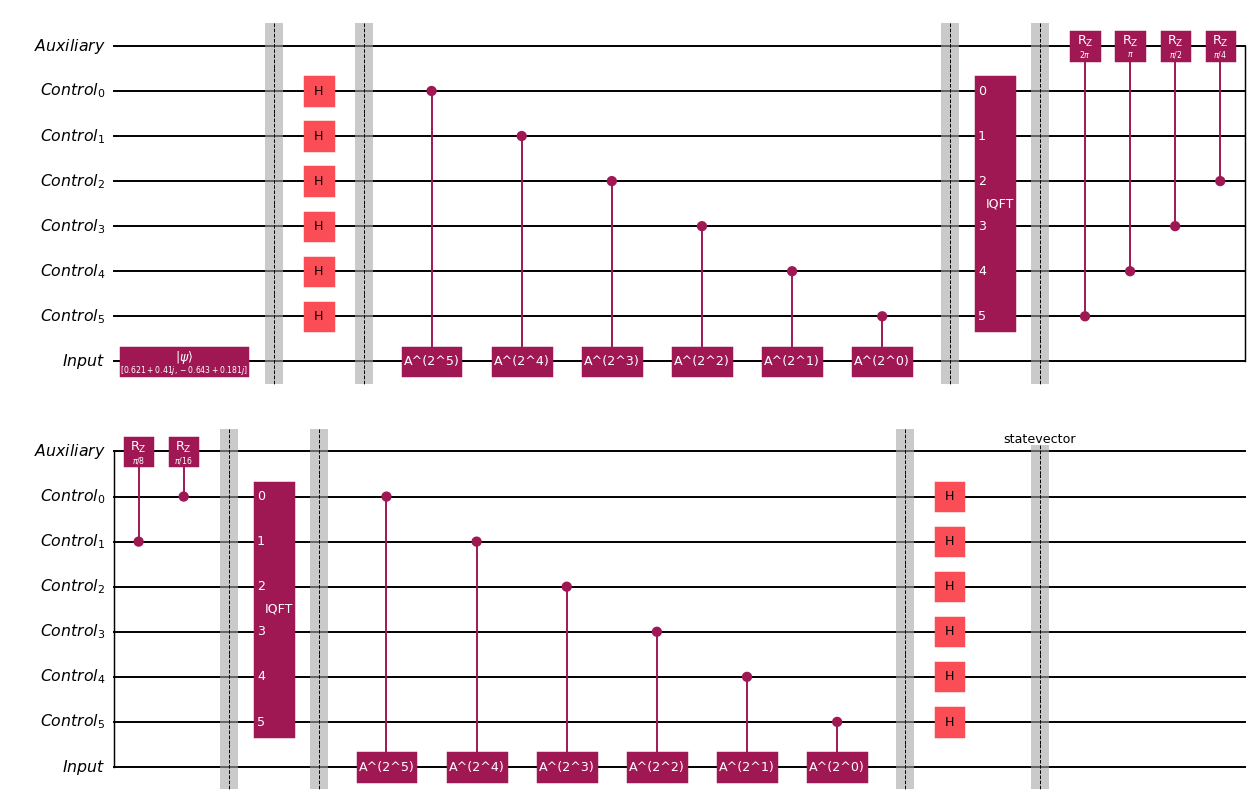

In [ ]:
# Draw he adpated HHL circuit
qc.draw("mpl",scale=0.7)

In [ ]:
###########################################
################ QCL-QPE ##################
###########################################

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import RealAmplitudes, UnitaryGate, QFT, UGate, StatePreparation
from qiskit_aer import AerSimulator
from qiskit import transpile
from sklearn.preprocessing import normalize
import cmath

AUX_CONT = 1
MAX_PREC = 20

control = QuantumRegister(AUX_CONT, "Control")
input = QuantumRegister(INPUT, "Input")
output = ClassicalRegister(MAX_PREC, "Output")

input_list = [input] if INPUT == 1 else input[0:INPUT]

ops = []
for i in range(MAX_PREC):
    ops.append(UnitaryGate(np.linalg.matrix_power(op_mat,2**i),f"A^(2^{i})").control(1))

qcl_qpe = QuantumCircuit(control, input, output)

# Initialize the input register
qcl_qpe.initialize(b_amps, input)

for i in reversed(range(MAX_PREC)):
    qcl_qpe.reset(control)
    qcl_qpe.h(control)
    qcl_qpe.append(ops[i],[control] + input_list)
    for k in reversed(range(MAX_PREC - i - 1)):
        qcl_qpe.p(cmath.pi / 2**(k+1), control).c_if(output[MAX_PREC - 2 - i - k],1)
    qcl_qpe.h(control)
    qcl_qpe.measure(control,output[MAX_PREC - 1 - i])

sim = AerSimulator()
tqcl_qpe = transpile(qcl_qpe, sim)


# Execute the circuit and get the statevector
result = sim.run(tqcl_qpe).result()
counts = result.get_counts(qcl_qpe)
print(counts)



In [ ]:
# Draw QCL QPE circuit
qcl_qpe.draw("mpl",scale=0.7,cregbundle=False)

In [ ]:
##################################
######### POST SELECTION #########
##################################

from math import ceil

# Eigenseries Quality evaluator
def f_l(p, l):
    good = p * np.sin(np.pi * (0.5)**l)**2
    bad = (1 - p)
    return 2 * np.sqrt(good + bad)

def optimal_t(bitstrings, epsilon):
    m = sum(bitstrings.values())
    s = MAX_PREC

    subsequences_info = []

    # Iterate over all possible lengths of subsequences
    for length in range(2, s + 1):
        # Iterate over all starting positions
        flag = False
        for start in range(s - length + 1):
            count = 0

            # Count how many bitstrings have the same subsequence of all 0's or all 1's
            for bitstring, c in bitstrings.items():
                subseq = bitstring[start:start + length]
                if subseq == '0' * length or subseq == '1' * length:
                    flag = True
                    count += c

            # Calculate the percentages
            percentage = (count / m)

            # Check if the subsequence appears in more than threshold bitstrings
            try:
                err = f_l(percentage,length)
            except:
                pass
            else:
                if err < epsilon:
                    subsequences_info.append((length, percentage, start, err))
            if percentage == 1.0:
                break
        if not flag:
            break

    return subsequences_info

print(optimal_t(counts,1.7))

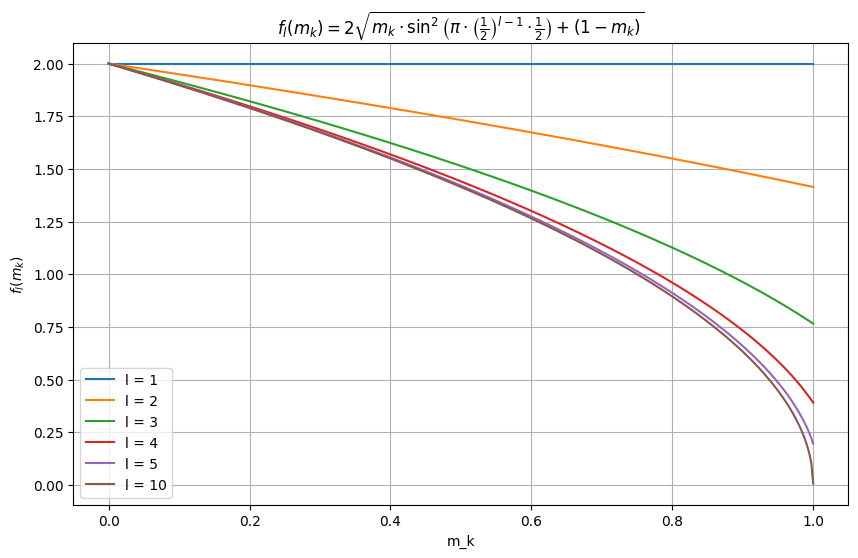

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define f_l(m)
def f_l(m, l):
    good = m * np.sin(np.pi * (0.5)**l)**2
    bad = (1 - m)
    return 2 * np.sqrt(good + bad)

# Set the values of l and the range of p
l_values = [1, 2, 3, 4, 5, 10]
m_values = np.linspace(0, 1, 400)

plt.figure(figsize=(10, 6))

for l in l_values:
    f_values = f_l(m_values, l)
    plt.plot(m_values, f_values, label=f'l = {l}')

plt.xlabel('m_k')
plt.ylabel(r'$f_l(m_k)$')
plt.title(r'$f_l(m_k) = 2 \sqrt{m_k\cdot\sin^2\left(\pi\cdot \left(\frac{1}{2}\right)^{l-1}\cdot\frac{1}{2}\right) + (1-m_k)}$')
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
###############################
######### SERIES PROB #########
###############################

import numpy as np
from math import ceil,log,sqrt,pi,asin
from scipy.special import binom
from itertools import combinations

def p_id(l):
    return 1/2**(l-1)

def d_score_prob(t_prime, l, d, m):
    t_ = t_prime - l + 1
    port = ceil(d * m)
    sum = 0
    for i in range(port,d+1):
        sum += binom(d,i) * (p_id(l)**i) * ((1-p_id(l))**(d-i))
    return 1- (1 - sum)**t_

def d_weight_prob(t_prime, l, d, mu, weights):
    assert len(weights) == d
    assert sum(weights) <= 1
    t_ = t_prime - l + 1
    res = 0
    for size in range(1, d + 1):
        for subset in combinations(weights, size):
            if sum(subset) >= mu:
                res += p_id(l)**size * (1 - p_id(l))**(d-size)
    return 1- (1-res)**t_

def t_prime(l,d,p_series):
    return -log(1-p_series) * 2**(d*(l-1)) +l-1

def m_min(epsilon):
    return 1 - (epsilon/2)**2

def l(epsilon, m):
    return -log(1/pi * asin(sqrt((epsilon/2)**2 - (1-m)/m)),2)

def lm_min_max(epsilon):
    min = (l(epsilon,1), 1)
    m = m_min(epsilon)
    print(m)
    max = (l(epsilon,0.875),m)
    return (min, max)
